# MNIST Denoising Diffusion Probabalistic Model

Writeup here

## Import Libraries

In [1]:
import torch
from torch import nn, optim
from model import DDPM, UNet
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

## MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

## Hyperparameters & Initialize Model

In [3]:
time_embedding_dimension = 100
number_of_steps = 1000
hidden_channels = 10
device = 'mps'

model = UNet(
    hidden_channels=hidden_channels,
    num_steps=number_of_steps,
    time_embedding_dim=time_embedding_dimension
)

ddpm = DDPM(
    unet=model,
    num_steps=number_of_steps,
    device=device
).to(device)

In [4]:
ddpm.load_state_dict(torch.load('ddpm.pt'))

<All keys matched successfully>

## Demo Forward Diffusion

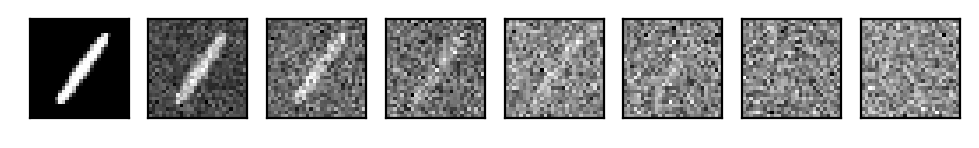

In [5]:
loader = DataLoader(dataset=data, batch_size=1, shuffle=True)
for image, _ in loader:
    ddpm.demo_forward(image, percents=(0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0))
    break

# Generated Images Before Training

In [6]:
# ddpm.generate_images((1, 4))

## Training Loop

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ddpm.parameters(), lr=1e-3)
loader = DataLoader(dataset=data, batch_size=256, shuffle=True)
epochs = 50
loss_history = []

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    for batch, (image, _) in enumerate(loader):
        image = image.to(device)
        n = image.shape[0]

        noise = torch.randn_like(image).to(device)
        t = torch.randint(0, number_of_steps, (n,)).to(device)

        noised_image = ddpm(image, t, noise)
        predicted_noise = ddpm.reverse(noised_image, t.reshape(n, -1))

        loss = criterion(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if batch % 10 == 0:
            loss_history.append(loss.item())

    print(f"Epoch {epoch + 1}/{epochs} | Average Loss: {epoch_loss/len(loader)}")

## Display Loss Curve

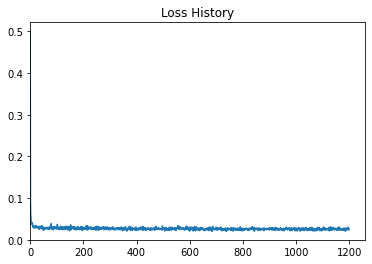

In [9]:
x_range = range(len(loss_history))
plt.plot(x_range, loss_history)
plt.title("Loss History")
plt.xlim(0)
plt.ylim(0)
plt.show()

## Generate Images After Training

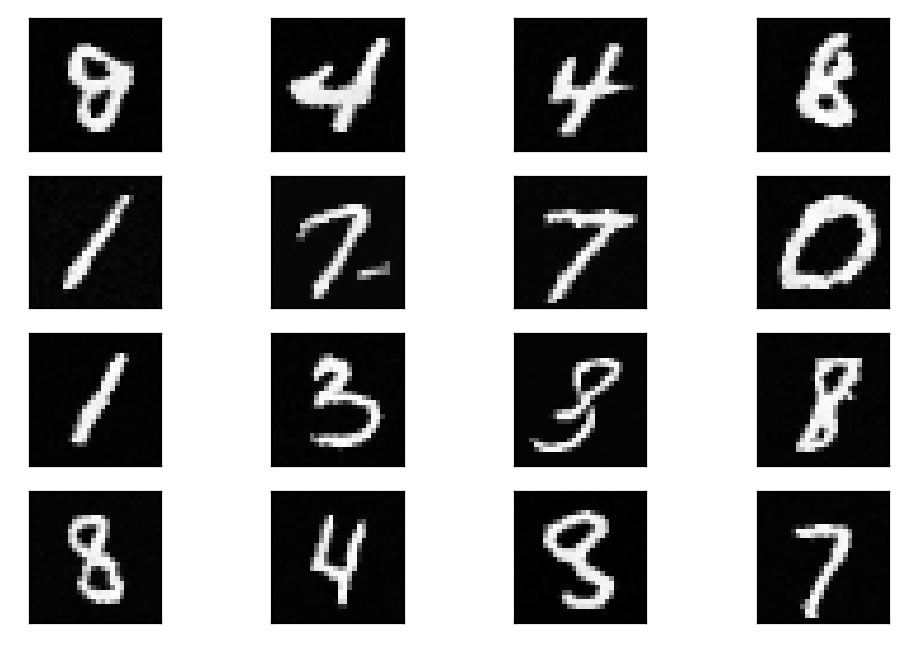

In [12]:
ddpm.generate_images((4, 4))

## Save Model

In [13]:
torch.save(ddpm.state_dict(), "ddpm.pt")